Machine Learning for Social Media-Based Depression Analysis
Business Understanding
Mental health is an urgent issue globally, with depression affecting millions of individuals across all demographics. The internet, and particularly social media, has become a place where people often express their struggles, including depression. Early detection of depression symptons can be crucial in providing timely support or intervention. This project’s goal is to leverage data science to better understand and detect depressive expressions in online platforms, potentially paving the way for more proactive mental health support. Given the widespread use of platforms like Reddit, this research could benefit individuals by increasing awareness and intervention opportunities

Data Understanding
Datasource: https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data

The dataset already includes several key features that can be used to analyze and predict depression indicators based on Reddit posts. Specifically, the data has 7 key columns:

subreddit : The subreddit where each post was made, with posts from "Depression" and "SuicideWatch" labeled as 1 for depression and posts from other subreddits labeled as 0 (non-depression).

title: The title of the Reddit post.

body: The full text of the Reddit post, which may contain valuable information for understanding the context, tone, and possible indicators of depression.

upvotes: Number of upvotes each post received, which may indicate the post's visibility or resonance with the community.

created_utc: The timestamp of when the post was created in UTC, which can help in analyzing temporal trends.

num_comments: The number of comments on each post, which could provide insights into community engagement.

label: The target variable indicating depression (1) or non-depression (0) based on subreddit. .... The raw data was collected from five Reddit subreddits (sub topics), categorized based on their content. These included: Teenagers, Depression, SuicideWatch, DeepThoughts, Happy

Since the data is already collected from Reddit, with over 6 million rows, further data acquisition may not be necessary. Infact, the team proposes reducing the dataset to about 500,000 rows for the purpose of this project(and to save our laptops). However, if additional data is needed, we could plan to scrape Reddit for more recent posts using a tool that we could identify through further research, provided we comply with Reddit's data collection policies and privacy standards.

In [226]:
#import libraries needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [227]:
#Load the dataset to use 
#data = pd.read_csv(file_path)  #
df = pd.read_csv("C:\\Users\\User\\OneDrive\\Desktop\\Flatiron\\Phase_five_final_06_11_2024\\final_project\\Data\\reduced_reddit.csv", index_col=False)

In [228]:
df.head(5)

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,NaN,4.0,1.619357e+09,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,1.554103e+09,NaN,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,1.649342e+09,12.0,0.0
3,teenagers,This isn't going to work out,NaN,236.0,1.417630e+09,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,1.569280e+09,4.0,0.0


In [229]:
#check the dataset information 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [230]:
#check on the description of numerical datatypes
df.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


Data Cleaning

In [231]:
#check to see if there are null values in percentage form
df.isnull().sum() / len(df) * 100

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

subreddit, title, upvotes, created_utc, label: These columns have no missing values (0%). 
Body: This column has 18.79% missing values, meaning around 18.8% of the rows have no data in the body.
num_comments: This column has 4.51% missing values

The dataset has some columns that have null values, namely body and num_comments. The latter has 18% of the rows with missing values while the former has averagely 5% of missing values which we can drop these missing rows as it makes a small percentage of the data. For the body column, I will impute the missing values by filling with the text "no content".

In [232]:
# Now you can fill missing values in 'body' column for the new 'data_main'
df['num_comments'] = df['num_comments'].fillna(0)

# Check the DataFrame info again to confirm the change
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [233]:
df.isnull().sum()

subreddit           0
title               0
body            18455
upvotes             0
created_utc         0
num_comments        0
label               0
dtype: int64

In [234]:
# We fill the missing values in 'body' column for the new 'data_main'
df['body'] = df['body'].fillna("No content")

# Check the DataFrame info again to confirm the change
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [235]:
# Now you can fill missing values in 'body' column for the new 'data_main'
df['body'] = df['body'].fillna("No content")

# Check the DataFrame info again to confirm the change
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [236]:
#check for missing values 
df.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

In [237]:
# Convert 'created_utc' column from UTC epoch time to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

# To see the updated DataFrame

df

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,No content,4.0,2021-04-25 13:25:39,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,2019-04-01 07:19:57,0.0,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,2022-04-07 14:35:00,12.0,0.0
3,teenagers,This isn't going to work out,No content,236.0,2014-12-03 18:12:52,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,2019-09-23 23:07:59,4.0,0.0
...,...,...,...,...,...,...,...
98821,depression,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,8.0,2019-05-17 08:30:19,1.0,1.0
98822,SuicideWatch,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",12.0,2012-10-20 17:24:21,8.0,1.0
98823,SuicideWatch,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",14.0,2015-05-19 22:19:26,4.0,1.0
98824,depression,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",323.0,2012-12-16 15:44:18,28.0,1.0



Exploratory Data Analysis

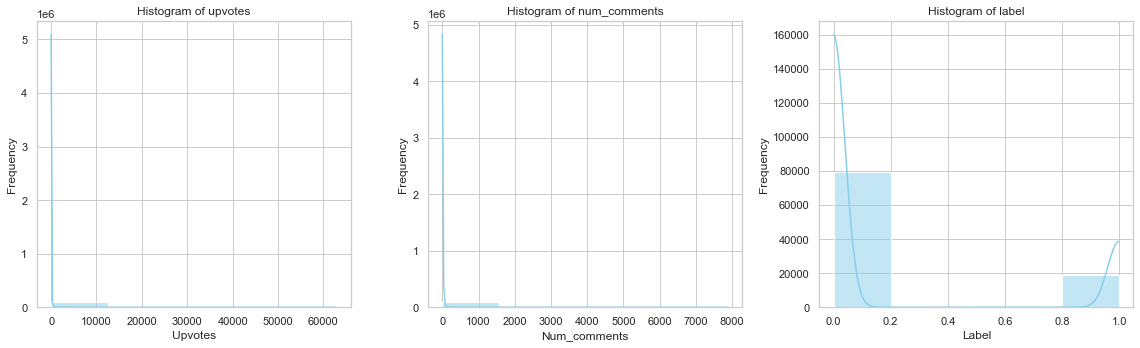

In [238]:
#Visualize the frequency distribution of values using histograms and to identify outliers using the box plots- for upvotes and num_comments

sns.set(style="whitegrid")
numeric_columns = ['upvotes', 'num_comments', 'label']

# Set up the subplot grid
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(16, 5))

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], bins=5, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

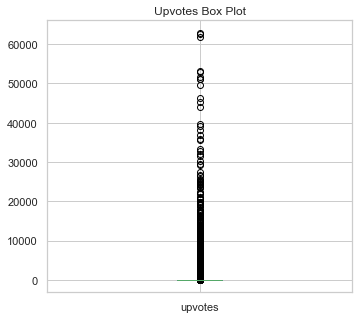

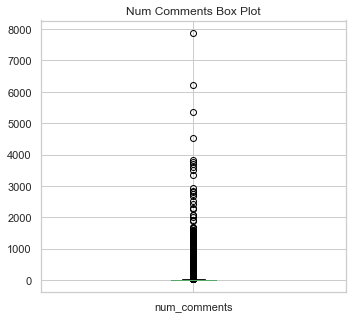

In [239]:
# Upvotes box plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
df['upvotes'].plot(kind='box')
plt.title('Upvotes Box Plot')
plt.show()

#for num_comments
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
df['num_comments'].plot(kind='box')
plt.title('Num Comments Box Plot')
plt.show()

teenagers       78251
depression      11672
SuicideWatch     7544
happy             995
DeepThoughts      364
Name: subreddit, dtype: int64
0.0    79610
1.0    19216
Name: label, dtype: int64


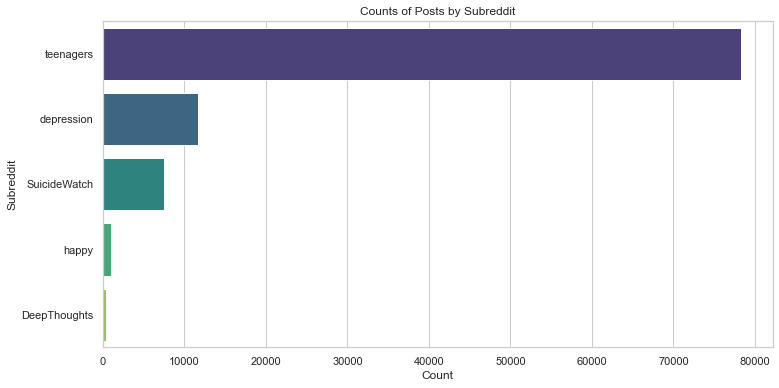

([<matplotlib.axis.XTick at 0x2465e05ec40>,
 [Text(0, 0, 'Non-suicidal'), Text(1, 0, 'Suicidal')])

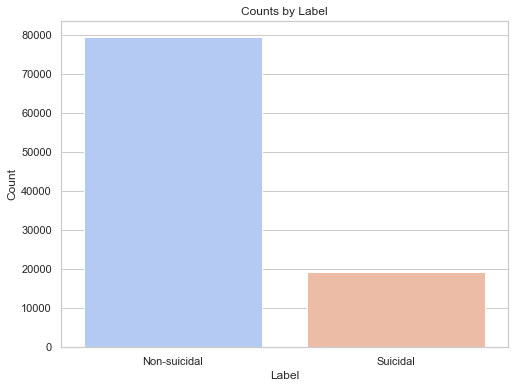

In [240]:
#Frequency of categorical columns

# Frequency of 'subreddit' column
print(df['subreddit'].value_counts())

# Frequency of 'label' column
print(df['label'].value_counts())

# Set style for plots
sns.set(style="whitegrid")

# Plot the counts for 'subreddit' column
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='subreddit', order=df['subreddit'].value_counts().index, palette='viridis')
plt.title('Counts of Posts by Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

# Plot the counts for 'label' column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='coolwarm')
plt.title('Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-suicidal', 'Suicidal'])

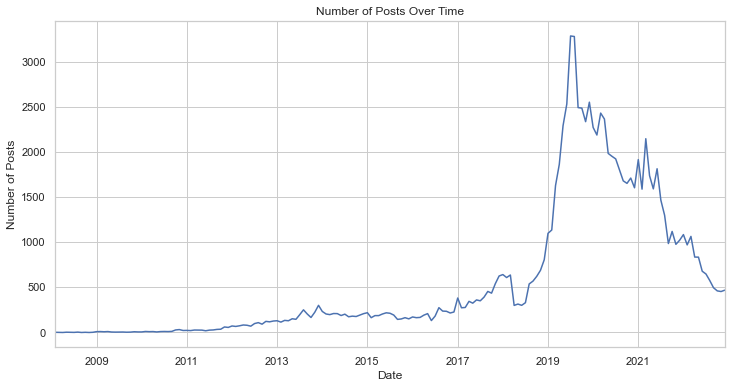

In [241]:
# Plot number of posts over time
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df.set_index('created_utc', inplace=True)

# Plot number of posts per month
df.resample('M').size().plot(figsize=(12, 6))
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

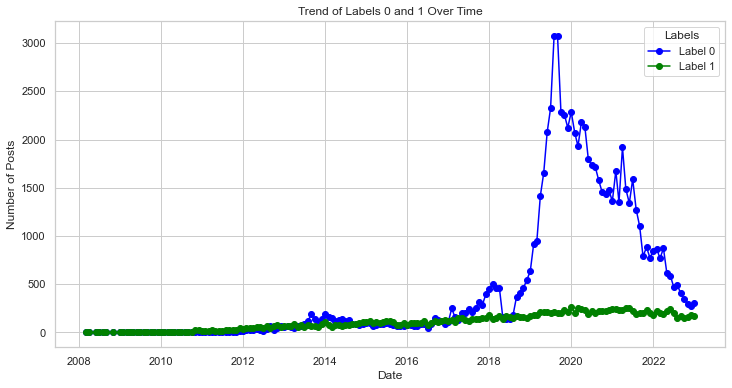

In [242]:
# Resample the data by month (change this to 'W' for weekly or 'D' for daily)
label_trend = df.resample('M')['label'].value_counts().unstack().fillna(0)

# Plot the trend over time for both labels
plt.figure(figsize=(12, 6))
plt.plot(label_trend.index, label_trend[0], label='Label 0', color='blue', marker='o')
plt.plot(label_trend.index, label_trend[1], label='Label 1', color='green', marker='o')

# Adding titles and labels
plt.title('Trend of Labels 0 and 1 Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Labels')
plt.grid(True)

# Show the plot
plt.show()


Bivariate Analysis

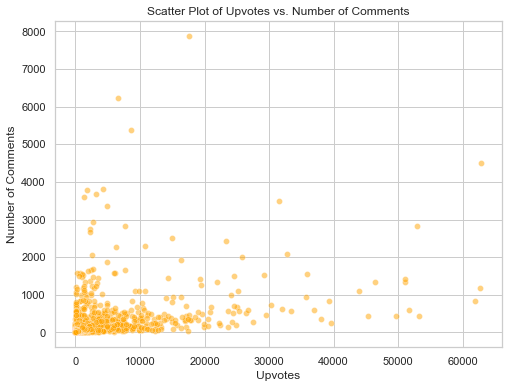

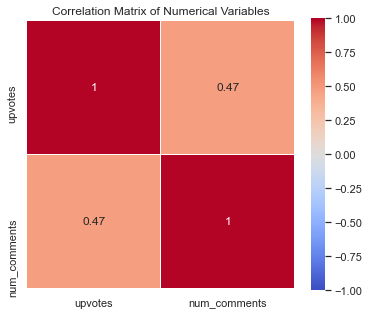

In [243]:
#Numerical vs. Numerical (Scatter plot and correlation matrix)
#Scatter Plot - Shows the relationship between two numerical variables, upvotes and num_comments.

# Scatter plot for numerical variables (Upvotes vs. Number of Comments)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='upvotes', y='num_comments', data=df, alpha=0.5, color='orange')
plt.title("Scatter Plot of Upvotes vs. Number of Comments")
plt.xlabel("Upvotes")
plt.ylabel("Number of Comments")
plt.show()

# Correlation matrix and heatmap
correlation_matrix = df[['upvotes', 'num_comments']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

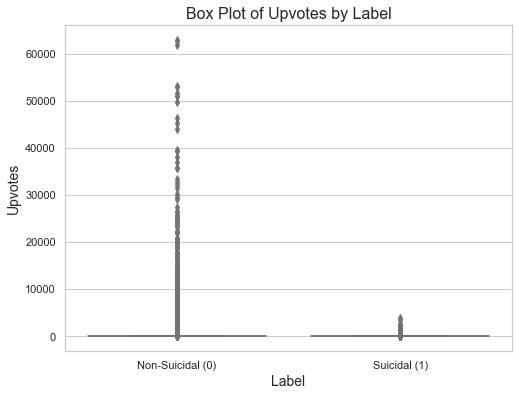

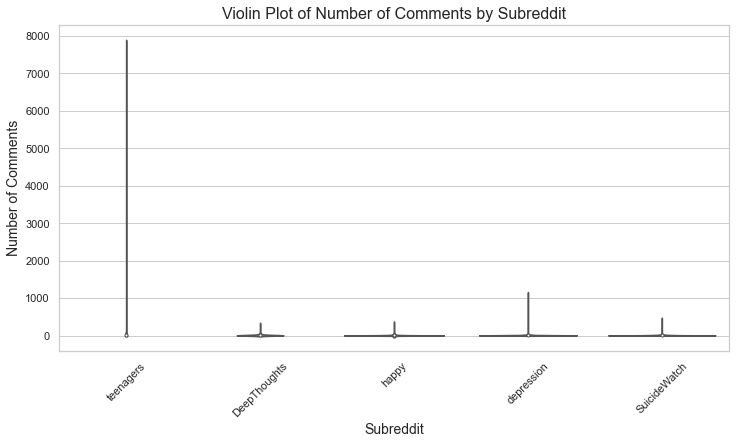

In [244]:
# Numerical vs. Categorical (Box plot and Violin plot)
# Box plot of 'upvotes' by 'label'

plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='upvotes', data=df, palette='pastel')
plt.title("Box Plot of Upvotes by Label", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Upvotes", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

# Violin plot of 'num_comments' by 'subreddit'
plt.figure(figsize=(12, 6))
sns.violinplot(x='subreddit', y='num_comments', data=df, palette='muted')
plt.title("Violin Plot of Number of Comments by Subreddit", fontsize=16)
plt.xlabel("Subreddit", fontsize=14)
plt.ylabel("Number of Comments", fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Crosstab of Subreddit by Label:
label           0.0    1.0
subreddit                 
DeepThoughts    364      0
SuicideWatch      0   7544
depression        0  11672
happy           995      0
teenagers     78251      0


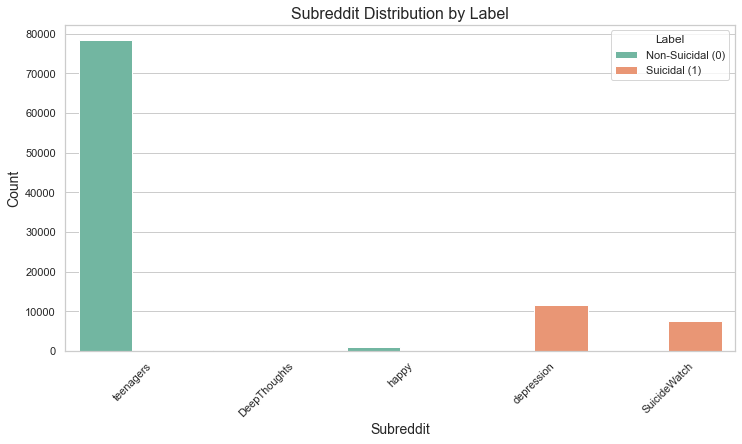

In [245]:
# Crosstab between 'subreddit' and 'label'

crosstab = pd.crosstab(df['subreddit'], df['label'])
print("Crosstab of Subreddit by Label:")
print(crosstab)

# Bar plot for 'subreddit' and 'label'
plt.figure(figsize=(12, 6))
sns.countplot(x="subreddit", hue="label", data=df, palette="Set2")  # Correct 'data=df'
plt.title("Subreddit Distribution by Label", fontsize=16)
plt.xlabel("Subreddit", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Label", loc='upper right', labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Multivariate Analysis

In [246]:
df.columns  # Check all column names

Index(['subreddit', 'title', 'body', 'upvotes', 'num_comments', 'label'], dtype='object')

In [247]:
# Convert 'created_utc' to Unix timestamp (numerical format)
df['created_utc'] = df['created_utc'].astype(int) / 10**9  # Convert to seconds

# Pair plot with 'label' as the hue, including 'created_utc'
sns.pairplot(df[['upvotes', 'num_comments', 'created_utc', 'label']], hue='label', palette='Set1', diag_kind='kde')
plt.suptitle("Pair Plot of Numerical Variables by Label", y=1.02)
plt.show()

KeyError: 'created_utc'

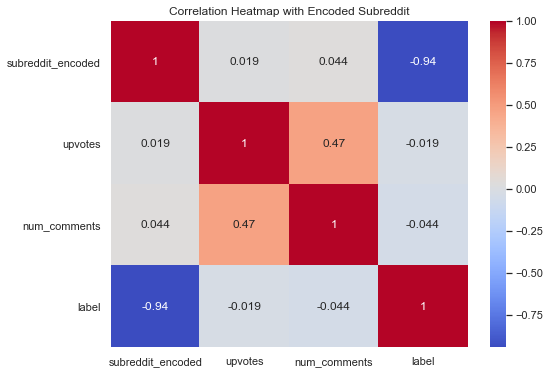

In [ ]:
# Convert the 'subreddit' column to numeric using label encoding
df['subreddit_encoded'] = LabelEncoder().fit_transform(df['subreddit'])

# Now include the encoded 'subreddit' in the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['subreddit_encoded', 'upvotes', 'num_comments', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Encoded Subreddit')
plt.show()

                                                                 title  \
created_utc                                                              
2021-04-25 13:25:39                        Day 18 of doing 50 push-ups   
2019-04-01 07:19:57  There isn’t a better feeling than finishing yo...   
2022-04-07 14:35:00  LMAOOO I can only get this guy to talk to me i...   
2014-12-03 18:12:52                       This isn't going to work out   
2019-09-23 23:07:59  Am I the only guy who found it hurtful as a ch...   

                                                                  body  \
created_utc                                                              
2021-04-25 13:25:39                                         No content   
2019-04-01 07:19:57  Then your teacher hits you with that “ Good jo...   
2022-04-07 14:35:00                              Yeahhh maybe not babe   
2014-12-03 18:12:52                                         No content   
2019-09-23 23:07:59   \n\nLike... why

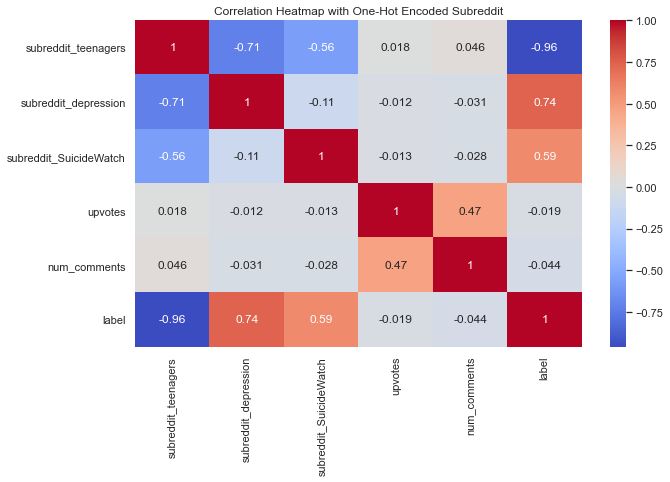

In [ ]:
# One-hot encoding the 'subreddit' column
df_encoded = pd.get_dummies(df, columns=['subreddit'], drop_first=True)

# Check the first few rows of the encoded DataFrame
print(df_encoded.head())

# Now, let's create the correlation heatmap again with the one-hot encoded 'subreddit' columns
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded[['subreddit_teenagers', 'subreddit_depression', 'subreddit_SuicideWatch', 'upvotes', 'num_comments', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with One-Hot Encoded Subreddit')
plt.show()

In [ ]:
# --- 1. Feature Creation ---
# Convert 'created_utc' to datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Extract year, month, day, hour from 'created_utc'
df['year'] = df['created_utc'].dt.year
df['month'] = df['created_utc'].dt.month
df['day'] = df['created_utc'].dt.day
df['hour'] = df['created_utc'].dt.hour

# Create additional features like ratios or flags
df['upvotes_per_comment'] = df['upvotes'] / (df['num_comments'] + 1)  # Adding 1 to avoid division by zero
df['has_body'] = df['body'].apply(lambda x: 0 if x == 'No content' else 1)  # Flag indicating if there's content in 'body'

# --- 2. Feature Encoding ---
# Encode the 'subreddit' categorical feature using one-hot encoding
df = pd.get_dummies(df, columns=['subreddit'], drop_first=True)

# --- 3. Scaling and Normalization ---
# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standard Scaling on numerical features
df[['upvotes', 'num_comments', 'upvotes_per_comment']] = standard_scaler.fit_transform(
    df[['upvotes', 'num_comments', 'upvotes_per_comment']]
)

# Apply Min-Max Scaling on year, month, day, hour (optional)
df[['year', 'month', 'day', 'hour']] = minmax_scaler.fit_transform(
    df[['year', 'month', 'day', 'hour']]
)

# Display the final DataFrame
print(df)

                                                   title  \
0                            Day 18 of doing 50 push-ups   
1      There isn’t a better feeling than finishing yo...   
2      LMAOOO I can only get this guy to talk to me i...   
3                           This isn't going to work out   
4      Am I the only guy who found it hurtful as a ch...   
...                                                  ...   
98821       Has anyone ever had any problems with gangs?   
98822  Moments away from killing myself, not even bot...   
98823      I've grown used to being like this for years.   
98824  This speech from The Lord of the Rings really ...   
98825                              I just don't know....   

                                                    body   upvotes  \
0                                             No content -0.062214   
1      Then your teacher hits you with that “ Good jo... -0.059013   
2                                  Yeahhh maybe not babe -0.062214   

FEATURE ENGINEERING

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2

# Step 1: Load the dataset
df = pd.read_csv("C:\\Users\\User\\OneDrive\\Desktop\\Flatiron\\Phase_five_final_06_11_2024\\final_project\\Data\\reduced_reddit.csv", index_col=False)

# Step 2: Combine 'title' and 'body' columns for the full text
df['full_text'] = df['title'].fillna('') + " " + df['body'].fillna('')

# Step 3: Preprocess the text (remove non-alphabet characters, lowercase)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

df['processed_text'] = df['full_text'].apply(preprocess_text)

# Step 4: Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

# Step 5: Create labels (assuming 'label' is 0 for non-depressive and 1 for depressive posts)
y = df['label']

# Step 6: Apply chi-squared test to identify significant words
chi2_stat, p_val = chi2(X, y)

# Step 7: Get the feature names (words) and create a DataFrame with their p-values
words = np.array(vectorizer.get_feature_names())  # Use get_feature_names() instead of get_feature_names_out()
result = pd.DataFrame({'Word': words, 'Chi2 Stat': chi2_stat, 'P-Value': p_val})

# Step 8: Sort by p-value to identify most significant words
result = result.sort_values('P-Value', ascending=True)

# Step 9: Output the most significant words
print(result.head(20))  # Shows the top 20 most significant words

# Optionally, filter based on p-value threshold
significant_words = result[result['P-Value'] < 0.05]
print("Most significant words:")
print(significant_words)


            Word    Chi2 Stat  P-Value
32712       high  1659.861528      0.0
81984       week  2534.452233      0.0
83540      worst  1609.738033      0.0
39282       isnt  2077.195008      0.0
5538         bad  5266.070781      0.0
65418      sense  1507.412216      0.0
24692       fear  2031.499055      0.0
53683    parents  4205.248256      0.0
75312       told  4048.086157      0.0
83555      worth  2507.073812      0.0
83558  worthless  2637.653401      0.0
28480    getting  5095.418157      0.0
39325     issues  2536.084962      0.0
46139     mental  4574.666442      0.0
75444       took  1507.069281      0.0
53973   pathetic  1785.028876      0.0
24541     father  2256.088247      0.0
83601    wouldnt  2348.982711      0.0
55544      place  3106.645977      0.0
64992       self  3408.564941      0.0
Most significant words:
            Word    Chi2 Stat   P-Value
32712       high  1659.861528  0.000000
81984       week  2534.452233  0.000000
83540      worst  1609.738033  0.0000

In [ ]:
# Check for Missing Values ---
print(df.isnull().sum())  # Ensure no missing values before proceeding

# Display the final DataFrame
print(df.head())  # Show the first few rows to check the result

subreddit       0
title           0
body            0
upvotes         0
num_comments    0
label           0
dtype: int64
                     subreddit  \
created_utc                      
2021-04-25 13:25:39  teenagers   
2019-04-01 07:19:57  teenagers   
2022-04-07 14:35:00  teenagers   
2014-12-03 18:12:52  teenagers   
2019-09-23 23:07:59  teenagers   

                                                                 title  \
created_utc                                                              
2021-04-25 13:25:39                        Day 18 of doing 50 push-ups   
2019-04-01 07:19:57  There isn’t a better feeling than finishing yo...   
2022-04-07 14:35:00  LMAOOO I can only get this guy to talk to me i...   
2014-12-03 18:12:52                       This isn't going to work out   
2019-09-23 23:07:59  Am I the only guy who found it hurtful as a ch...   

                                                                  body  \
created_utc                                    

SENTIMENT ANALYSIS using Logostic Regression

In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import string

# Download NLTK stopwords
nltk.download('stopwords')

# --- Preprocess Text Data ---
def preprocess_text(text):
    """Function to preprocess text by lowercasing, removing punctuation, and stopwords."""
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    stop_words = set(stopwords.words('english'))  # Set of stopwords from NLTK
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# --- Text Preprocessing on 'title' and 'body' columns ---
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_body'] = df['body'].apply(preprocess_text)

# --- Combine Title and Body for Text Analysis ---
df['processed_text'] = df['processed_title'] + " " + df['processed_body']

# --- Define Features and Labels ---
X = df['processed_text']  # Features: text data
y = df['label']  # Labels: sentiment labels (0 = negative, 1 = positive, 2 = neutral)

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build the Pipeline ---
# We will use TF-IDF Vectorizer and Logistic Regression together in a pipeline
model = make_pipeline(
    TfidfVectorizer(max_features=5000),  # Convert text data into numerical form (max 5000 features)
    LogisticRegression(max_iter=1000)    # Train a Logistic Regression classifier
)

# --- Train the Model ---
model.fit(X_train, y_train)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# --- Evaluate the Model ---
print("Accuracy:", accuracy_score(y_test, y_pred))  # Overall accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Precision, Recall, F1-Score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9370130527167864

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     15998
         1.0       0.89      0.76      0.82      3768

    accuracy                           0.94     19766
   macro avg       0.92      0.87      0.89     19766
weighted avg       0.94      0.94      0.94     19766



Preprocessing the Text:

We apply a function preprocess_text that performs the following:
Converts text to lowercase.
Removes punctuation.
Removes stopwords (common words like "the", "is", "and", etc.).
Combining Title and Body:

Since both the title and body contain important text information, we combine both to form a new column processed_text, which will be used for analysis.
TF-IDF Vectorization:

We use TfidfVectorizer to convert the text into numerical form. The parameter max_features=5000 limits the number of features to 5000 to prevent overfitting and ensure manageable model complexity.
Logistic Regression Classifier:

A Logistic Regression model is used for classification. 

SENTIMENT ANALYSIS using Naives Bayes

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# --- Preprocess Text Data ---
def preprocess_text(text):
    """Function to preprocess text by lowercasing, removing punctuation, and stopwords."""
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    stop_words = set(stopwords.words('english'))  # Set of stopwords from NLTK
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# --- Text Preprocessing on 'title' and 'body' columns ---
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_body'] = df['body'].apply(preprocess_text)

# --- Combine Title and Body for Text Analysis ---
df['processed_text'] = df['processed_title'] + " " + df['processed_body']

# --- Define Features and Labels ---
X = df['processed_text']  # Features: text data
y = df['label']  # Labels: sentiment labels (0 = negative, 1 = positive, 2 = neutral)

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build the Pipeline ---
# We will use TF-IDF Vectorizer and Multinomial Naive Bayes together in a pipeline
model = make_pipeline(
    TfidfVectorizer(max_features=5000),  # Convert text data into numerical form (max 5000 features)
    MultinomialNB()                      # Train a Multinomial Naive Bayes classifier
)

# --- Train the Model ---
model.fit(X_train, y_train)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# --- Evaluate the Model ---
print("Accuracy:", accuracy_score(y_test, y_pred))  # Overall accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Precision, Recall, F1-Score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9280076899726803

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     15998
         1.0       0.88      0.72      0.79      3768

    accuracy                           0.93     19766
   macro avg       0.91      0.85      0.87     19766
weighted avg       0.93      0.93      0.93     19766



SENTIMENT ANALYSIS using SVM

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
# --- Preprocess Text Data ---
def preprocess_text(text):
    """Function to preprocess text by lowercasing, removing punctuation, and stopwords."""
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    stop_words = set(stopwords.words('english'))  # Set of stopwords from NLTK
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# --- Text Preprocessing on 'title' and 'body' columns ---
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_body'] = df['body'].apply(preprocess_text)

# --- Combine Title and Body for Text Analysis ---
df['processed_text'] = df['processed_title'] + " " + df['processed_body']

# --- Define Features and Labels ---
X = df['processed_text']  # Features: text data
y = df['label']  # Labels: sentiment labels (0 = negative, 1 = positive, 2 = neutral)

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build the Pipeline ---
# We will use TF-IDF Vectorizer and Support Vector Machine (SVM) together in a pipeline
model = make_pipeline(
    TfidfVectorizer(max_features=5000),  # Convert text data into numerical form (max 5000 features)
    LinearSVC()                          # Train a Linear Support Vector Classifier (SVM)
)

# --- Train the Model ---
model.fit(X_train, y_train)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# --- Evaluate the Model ---
print("Accuracy:", accuracy_score(y_test, y_pred))  # Overall accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Precision, Recall, F1-Score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9395426489932207

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     15998
         1.0       0.88      0.79      0.83      3768

    accuracy                           0.94     19766
   macro avg       0.91      0.88      0.90     19766
weighted avg       0.94      0.94      0.94     19766



Eenhancing preprocessing with lemmatization and stopword removal

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Stopwords list
stop_words = set(stopwords.words('english'))

# Preprocessing function with lemmatization
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

# Apply preprocessing to 'title' and 'body' columns
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_body'] = df['body'].apply(preprocess_text)

# Combine processed title and body
df['processed_text'] = df['processed_title'] + " " + df['processed_body']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


Feature Extraction
After preprocessing, We need to convert the cleaned text into numerical representations that machine learning models can understand. Two common methods are Bag of Words (BoW) and TF-IDF (Term Frequency-Inverse Document Frequency).

TF-IDF is more advanced than BoW and adjusts for the frequency of terms that appear frequently across documents. It gives more importance to words that are specific to a document but not too frequent in the corpus as a whole.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the 'processed_text' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the number of features

# Fit and transform the training data
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Show the shape of the resulting matrix (number of documents, number of features)
print(X_tfidf.shape)

(98826, 5000)


Handling Text Classification

Now that We have prepared the text data and extracted features, we can apply a machine learning model for classification. We could experiment with other models as below;:

Logistic Regression

Naive Bayes

Random Forest

Deep Learning Models (e.g., LSTM, BERT)

LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9367095011636143

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     15998
         1.0       0.89      0.76      0.82      3768

    accuracy                           0.94     19766
   macro avg       0.92      0.87      0.89     19766
weighted avg       0.94      0.94      0.93     19766



Visualization using the logistic regression model

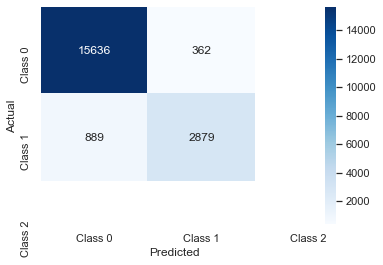

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Naive Bayes (MultinomialNB)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Initialize the Naive Bayes model
nb = MultinomialNB()

# Train the model
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9282606496003238

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     15998
         1.0       0.88      0.72      0.79      3768

    accuracy                           0.93     19766
   macro avg       0.91      0.85      0.87     19766
weighted avg       0.93      0.93      0.93     19766



Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Initialize the SVM model
svm_model = SVC(kernel='linear')  # Using a linear kernel for text classification

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.938530810482647

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     15998
         1.0       0.87      0.79      0.83      3768

    accuracy                           0.94     19766
   macro avg       0.91      0.88      0.90     19766
weighted avg       0.94      0.94      0.94     19766



Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9152079328139229

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     15998
         1.0       0.87      0.65      0.75      3768

    accuracy                           0.92     19766
   macro avg       0.90      0.81      0.85     19766
weighted avg       0.91      0.92      0.91     19766



K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8102296873419003

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      1.00      0.89     15998
         1.0       0.63      0.01      0.02      3768

    accuracy                           0.81     19766
   macro avg       0.72      0.50      0.46     19766
weighted avg       0.78      0.81      0.73     19766



Modeling

Train-Test Split: Before moving on to model building, it's important to split the dataset into training and testing sets. This ensures that to evaluate the model on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['label'])  # Features
y = df['label']  # Target

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (79060, 5)
Test Set Shape: (19766, 5)


Model Selection
Since we have a binary classification task (label is 0 or 1), we can start by trying out some common models like:

Logistic Regression (good baseline for binary classification)

Random Forest (a robust ensemble model)

Gradient Boosting (XGBoost or LightGBM for higher performance)

Support Vector Machines (SVM)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Step 1: Create the TF-IDF vectorizer for 'title' and 'body' columns
vectorizer_title = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for simplicity
vectorizer_body = TfidfVectorizer(max_features=1000)

# Step 2: Convert 'title' and 'body' columns into numeric features using TF-IDF
X_title = vectorizer_title.fit_transform(df['title'])
X_body = vectorizer_body.fit_transform(df['body'])

# Step 3: Concatenate the resulting features with the numeric features (e.g., 'upvotes', 'num_comments')
from scipy.sparse import hstack
X = hstack([X_title, X_body, df[['upvotes', 'num_comments']].values])

# Step 4: Set the target variable ('label')
y = df['label']

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train the model (Logistic Regression as an example)
model = LogisticRegression(max_iter=1000)  # Ensure the solver converges

# Fit the model on the training data
model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9362541738338561
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     15998
         1.0       0.89      0.76      0.82      3768

    accuracy                           0.94     19766
   macro avg       0.92      0.87      0.89     19766
weighted avg       0.93      0.94      0.93     19766



c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Explanation:
TF-IDF Vectorization:

We use TfidfVectorizer to convert the title and body columns into numeric form.
max_features=1000 limits the number of features to 1000 most important terms based on TF-IDF score.
Concatenating the features:

We concatenate the TF-IDF features from both the title and body columns with the numeric features (upvotes, num_comments). This is done using hstack from scipy.sparse to combine the sparse matrices from the text vectorization and the numeric columns.
Model Training:

A logistic regression model is trained on the processed data. The max_iter=1000 ensures that the solver has enough iterations to converge if needed.
Model Evaluation:

We evaluate the model using accuracy and the classification report, which gives you precision, recall, and F1-score for each class.
